In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
from plot_utils import plot_source_distributions, plot_ifa_parameters_and_ppc
%load_ext autoreload
%autoreload 2

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.0001


In [2]:
from testsuite import MAP_model, neg_log_lik

/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/im

In [3]:
from tfpmodels import *
from mapper import Mapper

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

In [5]:
sess = tf.InteractiveSession()

In [6]:
n_components_in_mixture = 5
n_sources = 2
n_features = 2
n_observations = 1000

In [7]:
#ifa_data = Mapper(centeredMarginalizedIndependentFactorAnalysis, 'ifa1', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*3, mixture_component_var_rate=1.*3,data_var_concentration=.1*3,data_var_rate=10.*3)
ifa_data = Mapper(mixtureOfGaussians, 'mog', observed_variable_names=['data'], n_observations=n_observations, n_components=4, n_features=n_features,mixture_component_means_var=0.1)
ifa_model = Mapper(centeredMarginalizedIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*1, mixture_component_var_rate=1.*1,data_var_concentration=.1*2,data_var_rate=10.*4)

In [8]:
generated = sess.run(ifa_data.tape)

In [20]:
#fica = FastICA(n_components=n_sources).fit(generated['data']).mixing_.T
#fica = np.concatenate([fica,np.random.randn(n_sources-n_features,n_features)],axis=0)

pca = PCA(n_components=n_sources).fit(generated['data']).components_.T
pca = np.concatenate([pca,np.random.randn(n_sources-n_features,n_features)],axis=0)

#loss, train_op = ifa_model.adam_optimizer(data=generated['data'], learning_rate=0.01)
loss, opt = ifa_model.bfgs_optimizer(data=generated['data'])
#loss, opt = ifa.cg_optimizer(data=generated['data'])
init_ops = []
#init_ops = [tf.global_variables_initializer()]

# Initialize in true parameters, as a sanity check
#true_parameters = dict(generated)
#true_parameters.pop('data')
#init_ops.append(ifa_model.assigner(**true_parameters))

# FastICA, large SNR, uniformish mixing weight initialization
#init_ops.append(tf.assign(ifa_model.unconstrained_variables['factor_loadings'], fica,name='initialize_directions'))
#init_ops.append(tf.assign(ifa_model.unconstrained_variables['mixture_component_var'], 10*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture),name='initialize_signal_variance'))
#init_ops.append(tf.assign(ifa_model.unconstrained_variables['data_var'], 1e-3*np.ones(ifa_model.unconstrained_variables['data_var'].shape),name='initialize_noise_variance'))
#init_ops.append(tf.assign(ifa_model.unconstrained_variables['mixture_weights'], np.ones(ifa_model.unconstrained_variables['mixture_weights'].shape)/n_components_in_mixture,name='initialize_noise_variance'))

#init_mixture_component_var = 10.*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture).astype(np.float32)
init_mixture_component_var = 10.*generated['data'].var()*np.ones((n_sources,n_components_in_mixture)).astype(np.float32)
init_data_var = 1.*np.ones(ifa_model.variable_shapes['data_var'],dtype=np.float32)
init_mixture_weights = np.ones(ifa_model.variable_shapes['mixture_weights'],dtype=np.float32)/n_components_in_mixture

init_ops.append(ifa_model.assigner(factor_loadings=pca.astype(np.float32),
                                   mixture_component_var=init_mixture_component_var,
                                   data_var=init_data_var,
                                   mixture_weights=init_mixture_weights))

#initialized_parameters = sess.run(ifa_model.variables)
#initialized_parameters.pop('sources')
#train_nll_init = neg_log_lik(initialized_parameters,centeredIndependentFactorAnalysisTest,generated['data'])
#sess.run(tf.assign(ifa_model.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))
accparams = []
learning_curve = []
def accumulate_parameters_and_loss(estimated_parameters, loss):
    accparams.append(estimated_parameters)
    learning_curve.append(loss)
sess.run(tf.global_variables_initializer())
sess.run([init_ops])
print(sess.run(ifa_model.map_neg_log_joint_fn(data=generated['data'])))

9510.93


In [21]:
sess.run(ifa_model.unconstrained_variables)

{'mixture_component_var': array([[-3.284183, -3.284183, -3.284183, -3.284183, -3.284183],
        [-3.284183, -3.284183, -3.284183, -3.284183, -3.284183]],
       dtype=float32), 'mixture_weights': array([[0., 0., 0., 0.],
        [0., 0., 0., 0.]], dtype=float32), 'factor_loadings': array([[-0.38867232,  0.92137617],
        [-0.92137617, -0.38867232]], dtype=float32), 'data_var': array([-6.9077563, -6.9077563], dtype=float32)}

In [22]:
sess.run(ifa_model.variables)

{'mixture_component_var': array([[36.11881, 36.11881, 36.11881, 36.11881, 36.11881],
        [36.11881, 36.11881, 36.11881, 36.11881, 36.11881]], dtype=float32),
 'mixture_weights': array([[0.2, 0.2, 0.2, 0.2, 0.2],
        [0.2, 0.2, 0.2, 0.2, 0.2]], dtype=float32),
 'factor_loadings': array([[-0.38867232,  0.92137617],
        [-0.92137617, -0.38867232]], dtype=float32),
 'data_var': array([0.99999994, 0.99999994], dtype=float32)}

In [23]:
opt.minimize(loss_callback=accumulate_parameters_and_loss,fetches=[ifa_model.variables, loss])

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: 4103.400391
  Number of iterations: 94
  Number of functions evaluations: 416


# ADAM training
t = []
num_epochs = 20000
sess.run(init_ops)
for i in range(num_epochs):
    sess.run(train_op)
    if i % 5 == 0:
        current_loss = sess.run(loss)
        t.append(current_loss)
plt.plot(np.arange(num_epochs,step=5)*5,t)

plot_ifa_parameters_and_ppc(sess.run(ifa_model.variables), generated, sess)

In [13]:
learning_curve[0]

9510.93

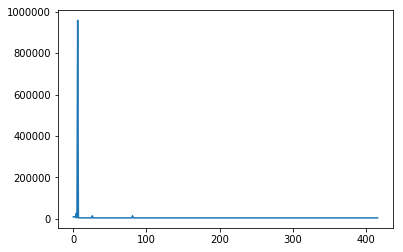

In [14]:
plt.plot(learning_curve)
#plt.ylim([-400000,400000])

In [15]:
testmodel = centeredMarginalizedIndependentFactorAnalysisTest(n_observations=n_observations, **ifa_model.variables)

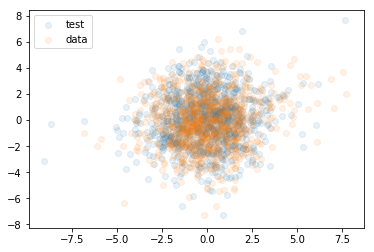

In [16]:
ppc = sess.run(testmodel)
plt.scatter(*ppc.T,alpha=0.1,label='test')
plt.scatter(*generated['data'].T,alpha=0.1,label='data')
plt.legend()
#plt.axis([-4,4,-4,4])

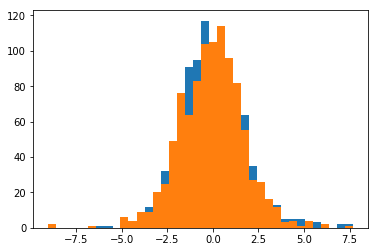

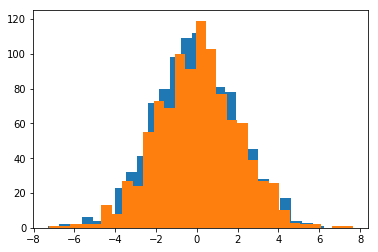

In [17]:
plt.hist(generated['data'][:,0],'auto')
plt.hist(ppc[:,0],'auto')
plt.show()
plt.hist(generated['data'][:,1],'auto');
plt.hist(ppc[:,1],'auto');

In [18]:
accparams[-1]

{'mixture_component_var': array([[1.4489257e+00, 1.4489257e+00, 1.4489257e+00, 1.4489257e+00,
         2.8315449e+00],
        [1.9303939e+00, 1.9303939e+00, 1.9303939e+00, 1.0121863e-03,
         1.0001361e-03]], dtype=float32),
 'mixture_weights': array([[1.9425827e-01, 1.9425827e-01, 1.9425827e-01, 1.9425827e-01,
         2.2296692e-01],
        [3.3333305e-01, 3.3333305e-01, 3.3333305e-01, 2.1267609e-17,
         8.8683288e-07]], dtype=float32),
 'factor_loadings': array([[-0.00469173, -0.00167032],
        [-0.05222419,  0.27561268]], dtype=float32),
 'data_var': array([0.001, 0.001], dtype=float32)}